# Imports

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from medmnist import NoduleMNIST3D
import scipy.ndimage as ndi
import random
from sklearn.utils.class_weight import compute_class_weight
from ipywidgets import interact, fixed
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [3]:
# import tensorflow as tf
# print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


#Utils

In [23]:
def normalize_volume(volume):
    volume = tf.cast(volume, tf.float32)
    mean_value = tf.reduce_mean(volume)
    std_value = tf.math.reduce_std(volume)
    return (volume - mean_value) / std_value
def normalize_dataset(images, labels, batch_size=16):
    image_dataset = tf.data.Dataset.from_tensor_slices(images)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    combined_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    normalized_dataset = combined_dataset.map(lambda image, label: (normalize_volume(image), label))
    # Batch the dataset
    batched_dataset = normalized_dataset.batch(batch_size)
    return batched_dataset

In [24]:
from sklearn.metrics import roc_curve, auc,confusion_matrix
def plot_roc_curve(model, val_dataset):
  y_true = []
  y_pred = []
  for x_batch, y_batch in val_dataset:
      y_true.extend(y_batch.numpy())
      y_pred.extend(model.predict(x_batch, verbose=0))
  #Calculate ROC curve
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  #Plot the curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [25]:
def plot_confusion_matrix(model,val_dataset):
  y_true = []
  y_pred = []
  for X_batch, y_batch in val_dataset:
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.round(model.predict(X_batch, verbose=0)))
  #confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)
  #Plot confusion matrix
  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  classes = ['Benign', 'Malignant']
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  thresh = conf_matrix.max() / 2.
  for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                  horizontalalignment="center",
                  color="white" if conf_matrix[i, j] > thresh else "black")
  plt.tight_layout()
  plt.show()

In [26]:
def tf_2_numpy(train_dataset):
  X_train_numpy = []
  y_train_numpy = []
  for batch in train_dataset:
      volumes, labels = batch
      volumes_numpy = volumes.numpy()
      labels_numpy = labels.numpy()
      for volume, label in zip(volumes_numpy, labels_numpy):
          X_train_numpy.append(volume)
          y_train_numpy.append(label)
  X_train_numpy = np.array(X_train_numpy)
  y_train_numpy = np.array(y_train_numpy)
  return X_train_numpy,y_train_numpy

In [27]:
def explore_images(image_data, label, predicted_label, slice_index=0):
    plt.figure(figsize=(5, 5))
    plt.imshow(image_data[:, :, slice_index], cmap='gray')
    plt.axis('off')
    plt.title(f"Slice {slice_index}, True: {label}, Predicted: {predicted_label}")
    plt.show()

In [28]:
def show_slices(image_data, label, predicted_label):
    num_slices = image_data.shape[2]
    num_cols = 7
    num_rows = (num_slices // num_cols) + (1 if num_slices % num_cols != 0 else 0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))
    fig.suptitle('All Slices of an Image (Label: {}, Predicted: {})'.format(label, predicted_label), fontsize=16)
    for i in range(num_slices):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        ax.imshow(image_data[:, :, i], cmap='gray')
        ax.axis('off')
        ax.set_title(f"Slice {i}\nTrue: {label}\nPred: {predicted_label}")
    for i in range(num_slices, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])
    plt.tight_layout()
    plt.show()

In [29]:
def class_count(labels):
  unique_labels, label_counts = np.unique(labels, return_counts=True)
  print('Benign = ',label_counts[0],' Malignant = ',label_counts[1])
  class_labels = {0: 'Benign', 1: 'Malignant'}
  plt.figure(figsize=(8, 6))
  plt.bar(unique_labels, label_counts, color='skyblue')
  plt.xlabel('Class Label')
  plt.ylabel('Count')
  plt.title('Count of Each Class Label')
  plt.xticks(list(class_labels.keys()), [class_labels[label] for label in unique_labels])
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()

# Load data

In [30]:
def load_data(batch_size):
  test_data = NoduleMNIST3D(split="test", download=True)

  test_imgs=test_data.imgs
  test_labels=test_data.labels

  print('Test dataset size = ',len(test_labels))
  class_count(test_labels)

  test_dataset=normalize_dataset(test_imgs,test_labels,batch_size=batch_size)

  return test_dataset

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Test dataset size =  310
Benign =  246  Malignant =  64


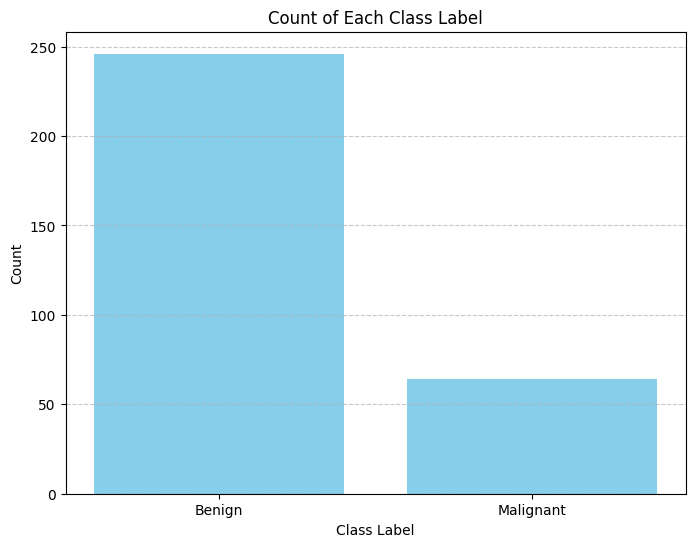

In [31]:
test_dataset=load_data(batch_size=8)

# Evaluate

In [32]:
# model_path = '/content/drive/MyDrive/Data/nodule/'
model_path=''

In [33]:
model=tf.keras.models.load_model(model_path+'model.h5')

In [41]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_45 (Conv3D)          (None, 26, 26, 26, 32)    896       
                                                                 
 conv3d_46 (Conv3D)          (None, 24, 24, 24, 32)    27680     
                                                                 
 batch_normalization_28 (Ba  (None, 24, 24, 24, 32)    128       
 tchNormalization)                                               
                                                                 
 max_pooling3d_27 (MaxPooli  (None, 12, 12, 12, 32)    0         
 ng3D)                                                           
                                                                 
 conv3d_47 (Conv3D)          (None, 10, 10, 10, 64)    55360     
                                                                 
 conv3d_48 (Conv3D)          (None, 8, 8, 8, 64)      

In [34]:
eval = model.evaluate(test_dataset, verbose=0)

In [35]:
print("Benchmark ACC =  0.874 , Model ACC = ",round(eval[1],3))
print("Benchmark AUC =  0.914 , Model AUC = ",round(eval[2],3))

Benchmark ACC =  0.874 , Model ACC =  0.861
Benchmark AUC =  0.914 , Model AUC =  0.912


# Visualization

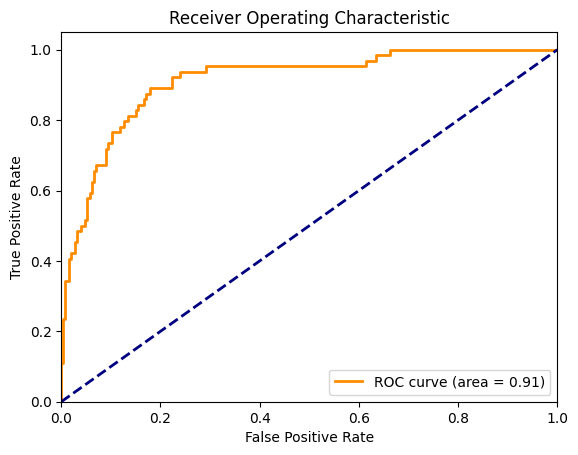

In [36]:
plot_roc_curve(model,test_dataset)

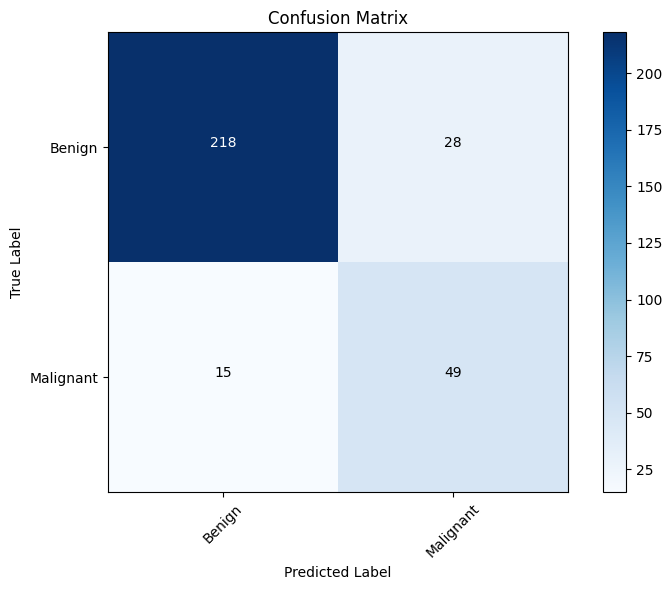

In [37]:
plot_confusion_matrix(model,test_dataset)

In [38]:
images_dataset,labels_dataset=tf_2_numpy(test_dataset)

<ipython-input-40-2ceccb7aa636>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label_text = label_mapping[int(true_label)]


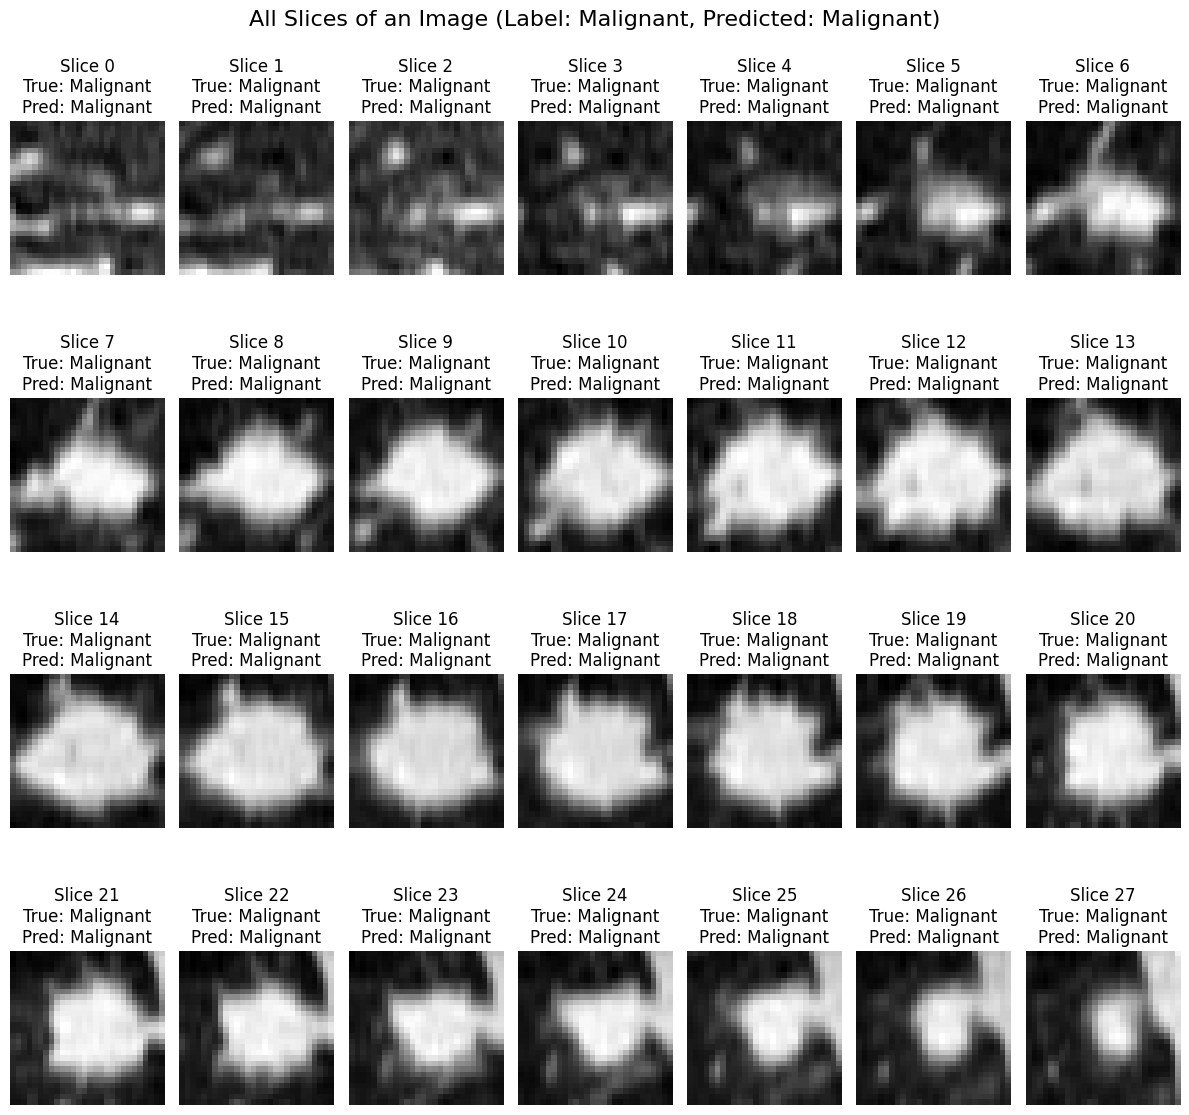

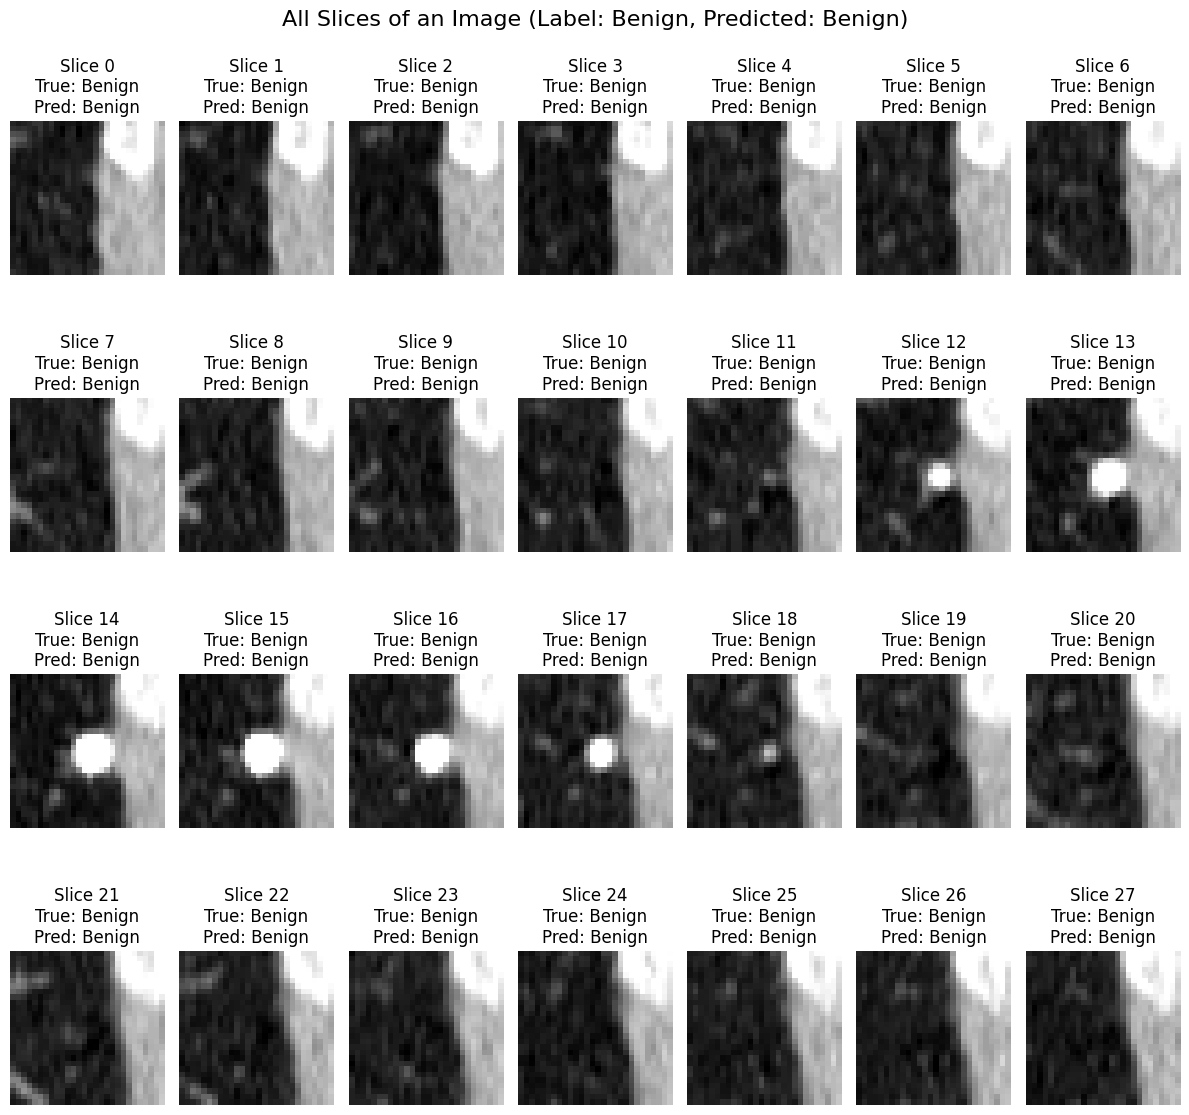

In [40]:
# Select random images and their corresponding labels
num_images_to_display = 10
random_indices = random.sample(range(len(images_dataset)), num_images_to_display)
random_images = [images_dataset[i] for i in random_indices]
random_labels = [labels_dataset[i] for i in random_indices]
# Make predictions on the random images
predicted_probabilities = model.predict(np.array(random_images),verbose=0)
# Convert probabilities to binary predictions
predicted_labels = [1 if prob > 0.5 else 0 for prob in predicted_probabilities]
# Define label mappings
label_mapping = {0: "Benign", 1: "Malignant"}
# Separate true and false predictions
true_predictions = []
false_predictions = []
for image_data, true_label, predicted_label in zip(random_images, random_labels, predicted_labels):
    if true_label == predicted_label:
        true_predictions.append((image_data, true_label, predicted_label))
    else:
        false_predictions.append((image_data, true_label, predicted_label))
# Display a mix of true and false predictions
num_samples_to_display = 5
samples_to_display = true_predictions[:num_samples_to_display // 2] + false_predictions[:num_samples_to_display // 2]
for image_data, true_label, predicted_label in samples_to_display:
    true_label_text = label_mapping[int(true_label)]
    predicted_label_text = label_mapping[int(predicted_label)]
    show_slices(image_data, true_label_text, predicted_label_text)
    # explore_images(image_data, true_label_text, predicted_label_text)